In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from ipydatagrid import DataGrid
from shapely.geometry import Polygon
from sklearn.neighbors import KDTree

### transformation en parquet

In [2]:
bornes = pd.read_csv('data/borne_de_recharge.csv')

In [3]:
bornes.to_parquet('data/bornes.parquet.gzip', compression='gzip')

### Premières explorations

In [4]:
bornes = pd.read_parquet('data/bornes.parquet.gzip')

In [5]:
bornes.shape #50936 bornes

(50936, 26)

In [6]:
#DataGrid(bornes)
bornes.head()

,nom_operateur,nom_enseigne,nom_station,implantation_station,adresse_station,code_insee_commune,nbre_pdc,puissance_nominale,prise_type_ef,prise_type_2,...,paiement_autre,horaires,accessibilite_pmr,date_mise_en_service,date_maj,last_modified,consolidated_longitude,consolidated_latitude,prix_kWh,prix_session
0,Izivia,ARCACHON,ARCACHON - AIGUILLON,Voirie,RUE DE LA PÉCHERIE,33009,1,7.0,False,True,...,True,24/7,Accessibilité inconnue,2021-05-19,2023-02-27,2023-02-27T01:50:25Z,-1.146988,44.656649,NaN,NaN
1,Izivia,ARCACHON,ARCACHON - PEREIRE,Voirie,AVENUE DU PARC PÉREIRE,33009,1,7.0,False,True,...,True,24/7,Accessibilité inconnue,2021-04-15,2023-02-27,2023-02-27T01:50:25Z,-1.193047,44.658496,NaN,NaN
2,Izivia,ARCACHON,ARCACHON - AIGUILLON,Voirie,RUE DE LA PÉCHERIE,33009,1,7.0,False,True,...,True,24/7,Accessibilité inconnue,2021-05-04,2023-02-27,2023-02-27T01:50:25Z,-1.146988,44.656649,NaN,NaN
3,Izivia,ARCACHON,ARCACHON - AIGUILLON,Voirie,RUE DE LA PÉCHERIE,33009,1,7.0,True,True,...,True,24/7,Accessibilité inconnue,2021-05-04,2023-02-27,2023-02-27T01:50:25Z,-1.146988,44.656649,NaN,NaN
4,Izivia,ARCACHON,ARCACHON - AIGUILLON,Voirie,RUE DE LA PÉCHERIE,33009,1,7.0,False,True,...,True,24/7,Accessibilité inconnue,2021-05-04,2023-02-27,2023-02-27T01:50:25Z,-1.146988,44.656649,NaN,NaN


In [333]:
bornes.puissance_nominale.value_counts()

22.00     26706
7.00       6337
18.00      3255
22.08      2401
50.00      2251
          ...  
62.00         1
115.00        1
5.90          1
7.30          1
4.60          1
Name: puissance_nominale, Length: 72, dtype: int64

#### Rajout du département

In [9]:
bornes['departement'] = bornes.code_insee_commune.str.slice(0,2)

In [10]:
bornes = stations = gpd.GeoDataFrame(bornes, geometry=gpd.points_from_xy(bornes.consolidated_longitude, bornes.consolidated_latitude), crs='epsg:4326')
bornes = bornes.to_crs('epsg:2154')

In [ ]:
bornes.explore()

### Un peu de carto

Les zones blanches

In [173]:
size = 20000

In [174]:
bornes_buffer = bornes.buffer(size).unary_union

In [175]:
zones_blanches = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bornes_buffer).explode(index_parts=True), crs='epsg:2154')

<AxesSubplot:>

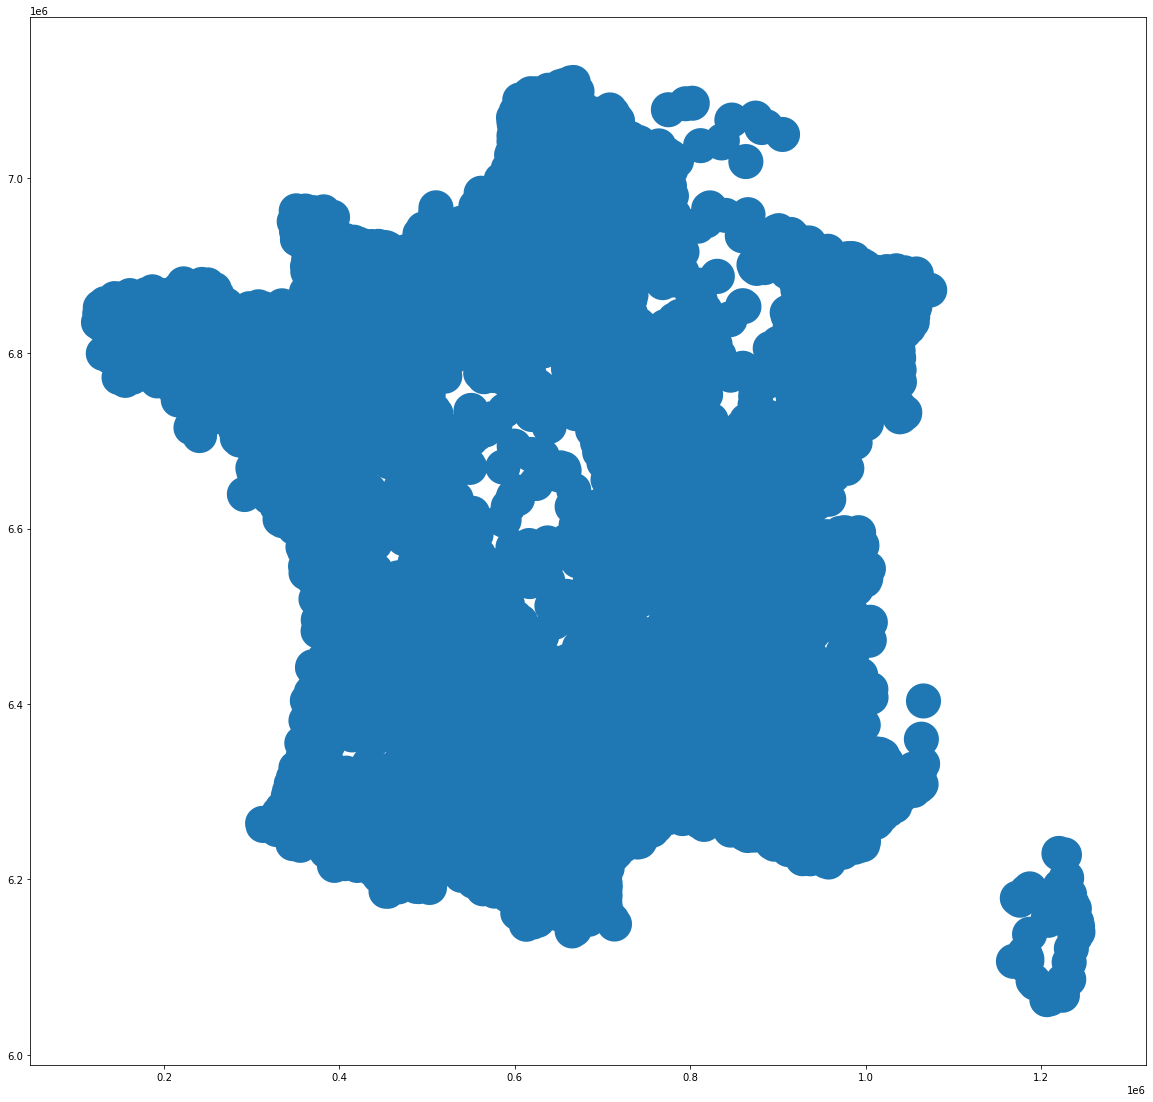

In [178]:
zones_blanches.cx[57313.330064:1318705.112211,5981358.013606:7187658.146073].plot(figsize=(20,20))

### Carroyage de l'info

In [ ]:
side = 20000

In [ ]:
bornes['x'] = np.floor(bornes.geometry.x / side) * side
bornes['y'] = np.floor(bornes.geometry.y / side) * side

In [ ]:
agg = bornes.groupby(['x', 'y'], as_index=False)['nbre_pdc'].sum()

In [ ]:
geometry = [ Polygon ([(x, y),
                       (x + side, y),
                       (x + side , y + side ),
                       (x, y + side )]) for x,y in zip( agg.x, agg.y)]

In [ ]:
agg = gpd.GeoDataFrame(agg, geometry=geometry)

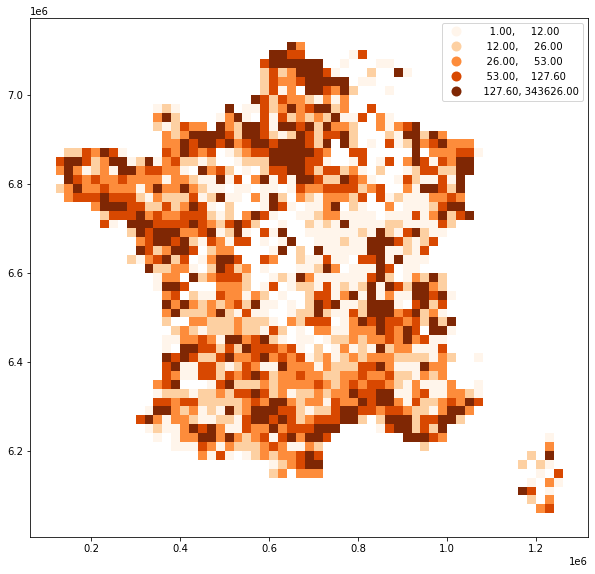

In [171]:
ax = agg.cx[57313.330064:1318705.112211,5981358.013606:7187658.146073].plot('nbre_pdc', scheme='quantiles', figsize=(10,10), cmap='Oranges', legend=True)

### Calcul de la bornes la plus proches

In [21]:
bornes['x'] = bornes.geometry.x
bornes['y'] = bornes.geometry.y

In [48]:
pixel = pd.read_csv('data/pixel_france.csv')

In [49]:
tree = KDTree(bornes[['x', 'y']])

In [50]:
dist, ind = tree.query(pixel, k=1)

In [51]:
pixel['distance_borne'] = dist

In [52]:
geometry = [ Polygon ([(x- 500, y-500),
                       (x + 500, y-500),
                       (x + 500 , y + 500 ),
                       (x-500, y+500  )]) for x,y in zip( pixel.x, pixel.y)]

In [53]:
pixel = gpd.GeoDataFrame(pixel, geometry=geometry, crs='epsg:2154' )

<AxesSubplot:>

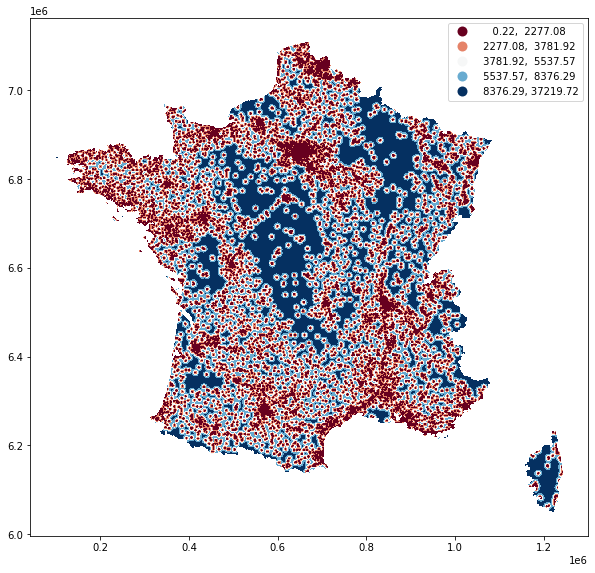

In [58]:
pixel.plot('distance_borne', scheme='quantiles', cmap='RdBu', legend=True, figsize=(10,10))

## Analyse des enseignes

In [14]:
side = 20000

In [15]:
bornes['un'] = 1

In [151]:
bornes.geometry.x.max()

14452860.825010845

In [16]:
bornes['x_agg'] = np.floor(bornes.geometry.x / side) * side
bornes['y_agg'] = np.floor(bornes.geometry.y / side) * side

In [136]:
operateur = bornes.groupby('nom_operateur', as_index=False)['un'].sum().sort_values('un')

In [137]:
operateur.loc[operateur.un>200,:]

,nom_operateur,un
48,ELECTRA,204
68,Fastned,235
210,ZEBORNE,248
189,Sodetrel,264
175,SIEGE 27,266
196,Total marketing france,276
49,ELECTRIC 55 CHARGING,362
118,Last Mile Solutions,367
98,IZIVIA,372
69,Freshmile,479


In [208]:
bornes.loc[bornes.nom_operateur.isin(operateur.loc[operateur.un<200,'nom_operateur']), 'nom_operateur']  = 'Petite'

In [209]:
bornes_agg = bornes.groupby(['x_agg', 'y_agg', 'nom_operateur'], as_index=False)['un'].sum()

In [210]:
bornes_agg=bornes_agg.pivot(index=['x_agg','y_agg'], columns='nom_operateur', values=['un'])

In [220]:
bornes_agg = bornes_agg['un'].reset_index()

In [221]:
geometry = [ Polygon ([(x, y),
                       (x + side, y),
                       (x + side , y + side ),
                       (x, y + side )]) for x,y in zip( bornes_agg.x_agg, bornes_agg.y_agg)]
bornes_agg = gpd.GeoDataFrame(bornes_agg, geometry=geometry, crs='epsg:2154' ).reset_index()

<AxesSubplot:>

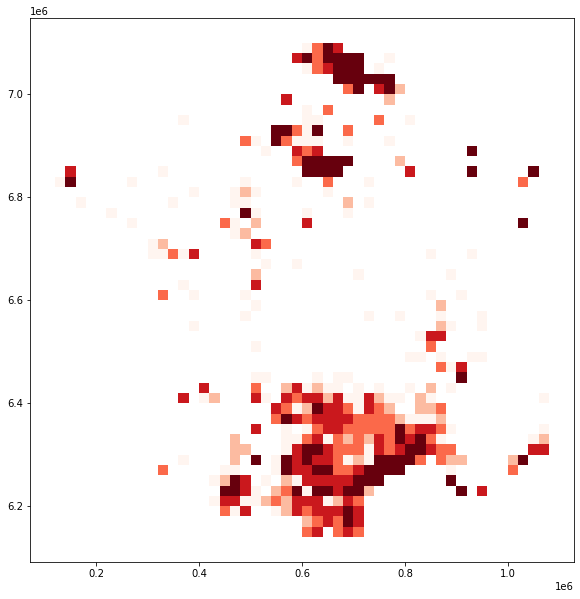

In [233]:
bornes_agg.cx[57313.330064:1318705.112211,5981358.013606:7187658.146073].plot('Bouygues E&S', scheme='quantiles', figsize=(10,10),cmap='Reds')

<AxesSubplot:>

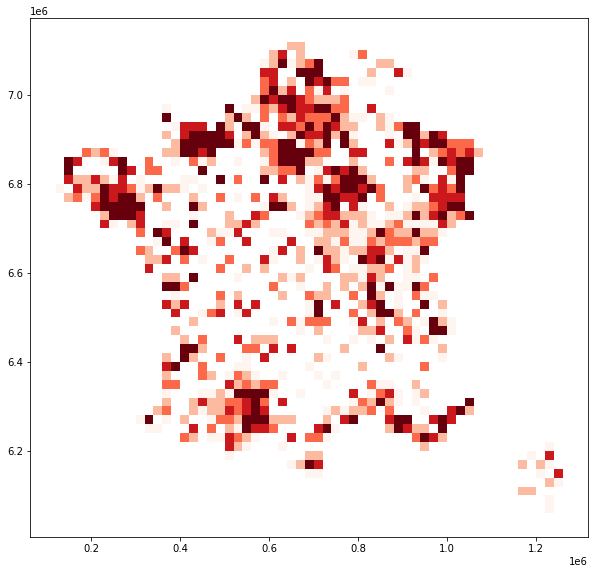

In [232]:
bornes_agg.cx[57313.330064:1318705.112211,5981358.013606:7187658.146073].plot('Freshmile SAS', scheme='quantiles', figsize=(10,10),cmap='Reds')

<AxesSubplot:>

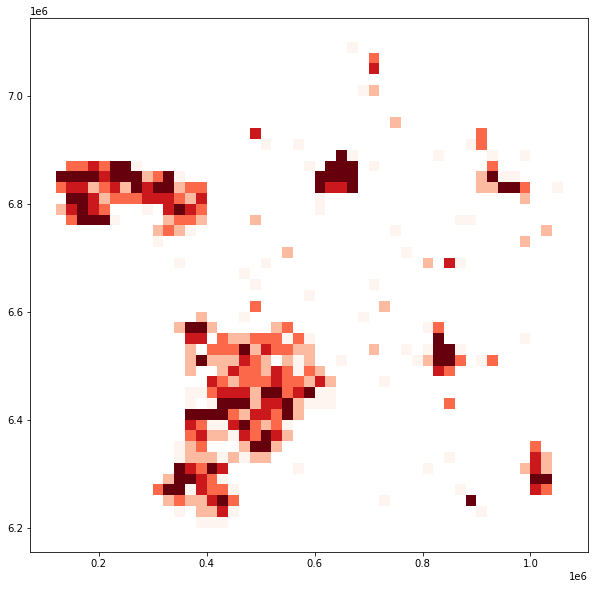

In [234]:
bornes_agg.cx[57313.330064:1318705.112211,5981358.013606:7187658.146073].plot('Izivia', scheme='quantiles', figsize=(10,10),cmap='Reds')

<AxesSubplot:>

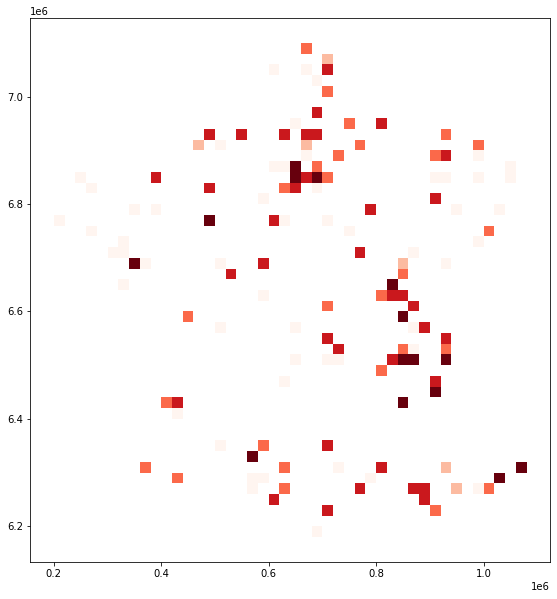

In [235]:
bornes_agg.cx[57313.330064:1318705.112211,5981358.013606:7187658.146073].plot('TotalEnergies Marketing France', scheme='quantiles', figsize=(10,10),cmap='Reds')


<AxesSubplot:>

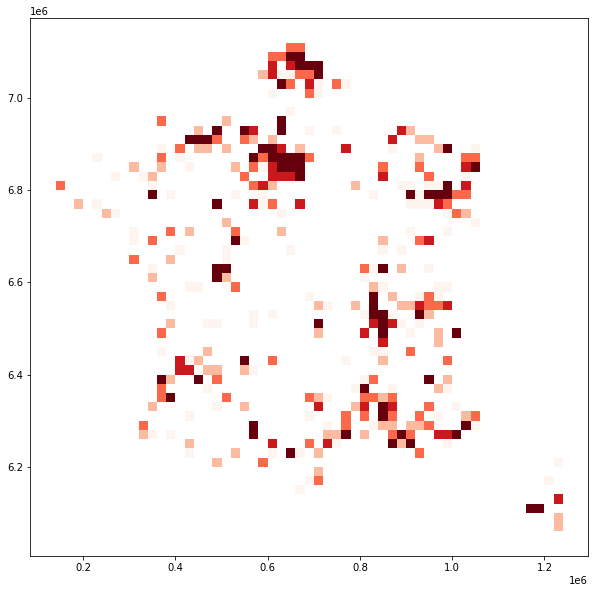

In [236]:
bornes_agg.cx[57313.330064:1318705.112211,5981358.013606:7187658.146073].plot('Petite', scheme='quantiles', figsize=(10,10),cmap='Reds')

### Payement et prix puissance

In [23]:
bornes.gratuit =bornes.gratuit *1
bornes.prix_kWh =bornes.prix_kWh *1
bornes['rapide'] = (bornes.puissance_nominale>=50)*1

In [30]:
paiement_agg = bornes[['x_agg', 'y_agg', 'gratuit', 'paiement_acte', 'paiement_cb', 'paiement_autre','prix_kWh']].groupby(['x_agg', 'y_agg'], as_index=False).mean()
paiement_agg = bornes[['x_agg', 'y_agg', 'gratuit', 'paiement_acte', 'paiement_cb', 'paiement_autre','prix_kWh', 'rapide']].groupby(['x_agg', 'y_agg'], as_index=False).agg(
    {
        'gratuit': ['mean'],
        'paiement_acte':['mean'],
        'paiement_cb':'mean',
        'paiement_autre':'mean',
        'prix_kWh': [ "mean"],
        'rapide':'mean'
    }
)

In [31]:
paiement_agg.columns = paiement_agg.columns.map(''.join)

In [32]:
paiement_agg

,x_agg,y_agg,gratuitmean,paiement_actemean,paiement_cbmean,paiement_autremean,prix_kWhmean,rapidemean
0,-13120000.0,17820000.0,0.000000,1.0,1.0,1.0,0.271818,0.00
1,-13100000.0,17860000.0,0.000000,1.0,1.0,1.0,0.271818,0.00
2,-13080000.0,17860000.0,0.000000,1.0,1.0,1.0,0.271818,0.00
3,-13040000.0,17900000.0,0.000000,1.0,1.0,1.0,0.271818,0.00
4,-6440000.0,4180000.0,0.000000,1.0,0.0,1.0,NaN,0.00
...,...,...,...,...,...,...,...,...
1369,10240000.0,460000.0,0.344828,1.0,1.0,1.0,0.178088,0.00
1370,10240000.0,500000.0,0.000000,1.0,1.0,1.0,0.271818,0.00
1371,10240000.0,540000.0,0.000000,1.0,1.0,1.0,0.270455,0.00
1372,10280000.0,500000.0,0.000000,1.0,1.0,1.0,0.271818,0.00


In [33]:
geometry = [ Polygon ([(x, y),
                       (x + side, y),
                       (x + side , y + side ),
                       (x, y + side )]) for x,y in zip( paiement_agg.x_agg, paiement_agg.y_agg)]
paiement_agg = gpd.GeoDataFrame(paiement_agg, geometry=geometry, crs='epsg:2154' ).reset_index()

<AxesSubplot:>

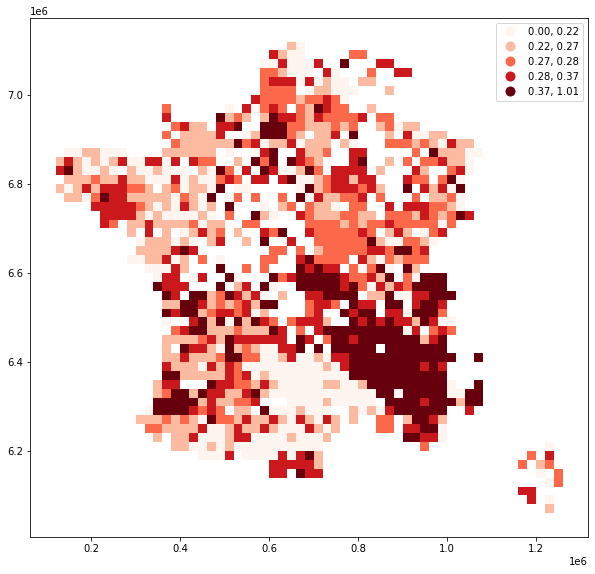

In [34]:
paiement_agg.cx[57313.330064:1318705.112211,5981358.013606:7187658.146073].plot('prix_kWhmean', scheme='quantiles', figsize=(10,10),cmap='Reds', legend=True)

In [269]:
np.mean(bornes.gratuit * 1)

0.15029870025026237

C:\ProgramData\Anaconda3\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\ProgramData\Anaconda3\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

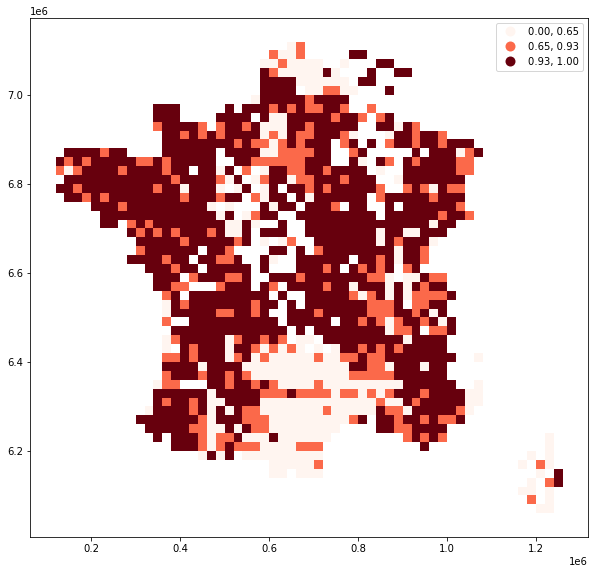

In [36]:
paiement_agg.cx[57313.330064:1318705.112211,5981358.013606:7187658.146073].plot('paiement_actemean', scheme='quantiles', figsize=(10,10),cmap='Reds', legend=True)

C:\ProgramData\Anaconda3\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\ProgramData\Anaconda3\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

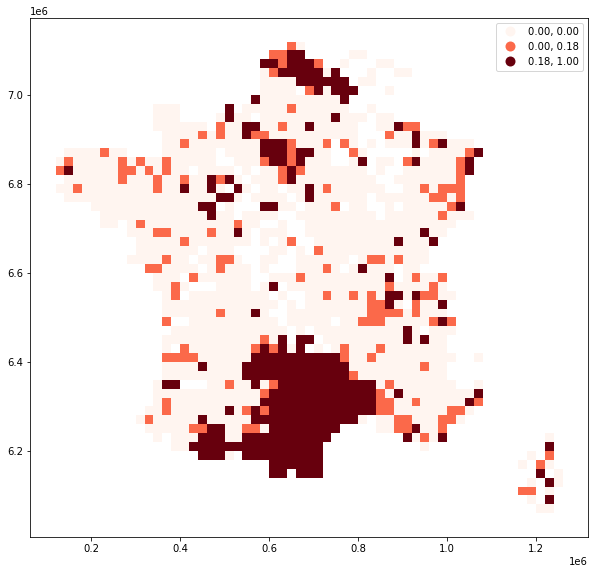

In [330]:
paiement_agg.cx[57313.330064:1318705.112211,5981358.013606:7187658.146073].plot('gratuitmean', scheme='quantiles', figsize=(10,10),cmap='Reds', legend=True)

C:\ProgramData\Anaconda3\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\ProgramData\Anaconda3\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

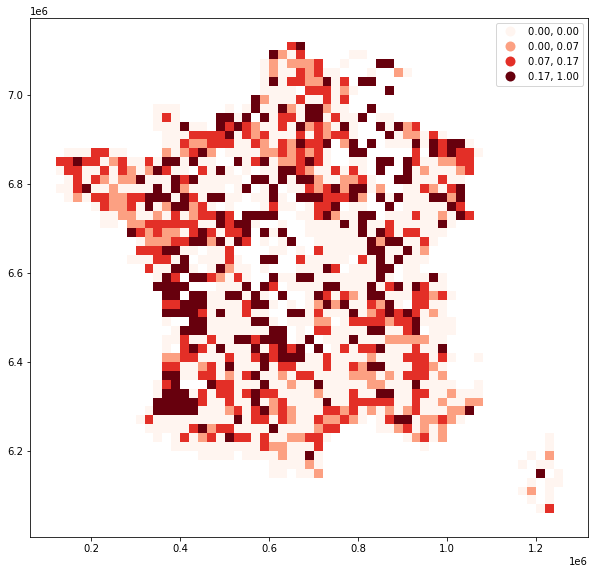

In [28]:
paiement_agg.cx[57313.330064:1318705.112211,5981358.013606:7187658.146073].plot('rapidemean', scheme='quantiles', figsize=(10,10),cmap='Reds', legend=True)